# Corpus EDA

In [5]:
import pandas as pd
import random

import string 
import re
import wordcloud
from PIL import Image
from os import path

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [70]:
eng_stopwords_and_punct = stopwords.words('english') + list(string.punctuation) + ['’', '“','”', "''", '""', '', '..', '...', '``', '—', '->', '’ ’']

# TweetTokenizer will put all text in the tweet to lowercase, strip out usernames/handles and reduce reated chars in words
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) 

lemmatizer = WordNetLemmatizer()


def clean_tokenize_lemmatize_tweet(tweet):
    ''' 
    Apply text cleaning, tokenization then lemmatization on the given tweet 
    '''
    #remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    #remove RT 
    tweet = re.sub(r'^RT\s+', '', tweet)
    #remove the # symbol
    tweet = re.sub('#', '', tweet)
    #remove words containing numbers
    tweet = re.sub(r'\w*\d\w*', '', tweet)
    #tokenize
    tokens = tweet_tokenizer.tokenize(tweet)
    # remove stopwords and punctuation
    tokens = [token for token in tokens if token not in eng_stopwords_and_punct]
    # remove tokens that are only 1 char in length
    tokens = [token for token in tokens if len(token)>1]
    #lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens


def split_content_by_sentiment(region_df):
    '''
    Create dataframes for each sentiment class from the provided dataframe
    '''
    pos = region_df[region_df['sentiment'] == 'positive']['content']
    neg = region_df[region_df['sentiment'] == 'negative']['content']
    neu = region_df[region_df['sentiment'] == 'neutral']['content']
    return [pos, neg, neu]


def perform_topic_modeling_and_plot(content, topic_num, top_word_count, plot_title):
    '''
    Perform topic modeing using on the provided corpus and plot the top words 
    for the designated number of topics.
    '''
    cv = CountVectorizer(max_df=0.95, min_df=0.01, strip_accents='unicode', tokenizer=clean_tokenize_lemmatize_tweet, ngram_range=(1,2))
    lda = LatentDirichletAllocation(max_iter=10, learning_method='online', n_components=topic_num, random_state=42)

    # Unsupervised learning...no need to do a test/train split here ;)
    dtm = cv.fit_transform(content)

    # This might take awhile if you are dealing with a large amount of documents!
    lda.fit(dtm)
    # plot the top words per topic
    feature_names = cv.get_feature_names()
    num_rows = 2
    if topic_num == 20:
        num_rows = 4
    elif topic_num == 5:
        num_rows = 1
    plot_top_words(lda, feature_names, top_word_count, plot_title, plot_num_rows=num_rows)
    return (lda, dtm, cv)


def plot_top_words(fitted_lda, feature_names, n_top_words, title, plot_num_rows):
    '''
    Plot the top words for the provided topic model|
    '''
    fig, axes = plt.subplots(plot_num_rows, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(fitted_lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5, color='blue', alpha=0.75)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=16)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.10)
    plt.show()

## Corpus Exploration: Topic Modeling

Now that we've assigned Sentiment to the Tweets, let's look into what people are tweeting about. I'm using unsupervised learning to perform Topic Modeling on each Sentiment group in the following way:
* Topics for Pos/Neg/Neu tweets from the entire United States 
* Topics for Pos/Neg/Neu tweets from the Southeast (this is the region where I currently live.) 
* Topics for Pos/Neg/Neu tweets from Alabama (this is the state where I currently live and most of my family members have children in k-12 in this state.) 

In [8]:
vetted_usa_tweets = pd.read_csv('../data/vetted_usa_tweets.csv')
southeast_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Southeast']
alabama_tweets = southeast_tweets[southeast_tweets['loc_state'] == 'AL']

In [9]:
entire_us_sentiment_series = split_content_by_sentiment(vetted_usa_tweets)
se_sentiment_series = split_content_by_sentiment(southeast_tweets)
alabama_sentiment_series = split_content_by_sentiment(alabama_tweets)

### Text Processing to prep for Topic Modeling

Before performing topic modeling using LatentDirichletAllocation (LDA), I'll need apply some text processing. When I trained the Text Classifier to detect sentiment, punctuation and capitalization could actually be useful to the classifer, so I only did very light text processing to the corpus before trainging the classifier. With Topic Modeling, it is more important to normalize the corpus text so I'll apply the following text processing to prepare.

* Change to lowercase  (TweetTokenizer handles this)
* Remove RT and # (will need a regex)
* Remove urls (will need a regex)
* Remove stopwords and punctuation
* Peform lemmatization (after all other cleaning applied, apply lemmatization)

Text processing and Topic Modeling are peformed in the __clean_tokenize_lemmatize_tweet__ and the __perform_topic_modeling__ functions 


## Question 4: What are the Topics for Positive, Negative, and Neutral Tweets in the US, the Southeast Region, and the state of Alabama?

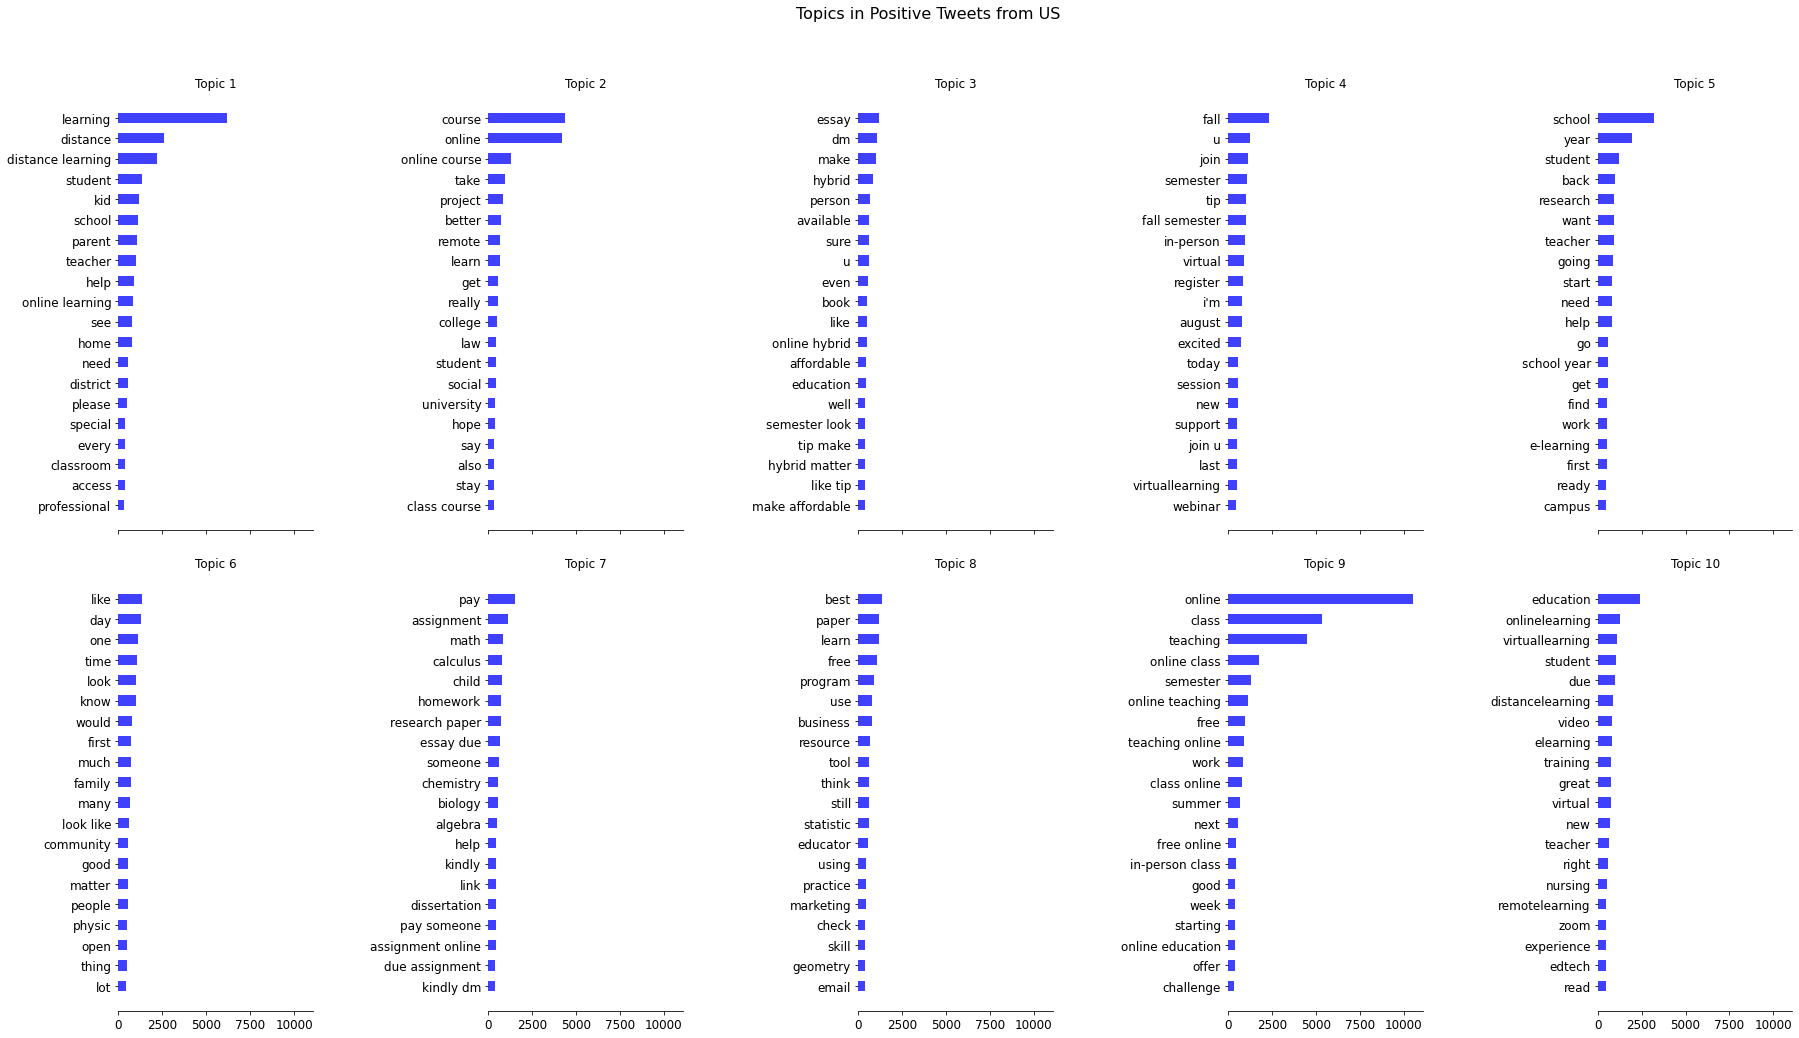

In [77]:
# US-wide Positive topic - Selecting 20 Topics instead of 10 as the Positive class was the majority class (73.9% of Tweets were Positive)
us_pos_tm_tuple = perform_topic_modeling_and_plot(content=entire_us_sentiment_series[0], topic_num=10, top_word_count=20, plot_title='Topics in Positive Tweets from US')

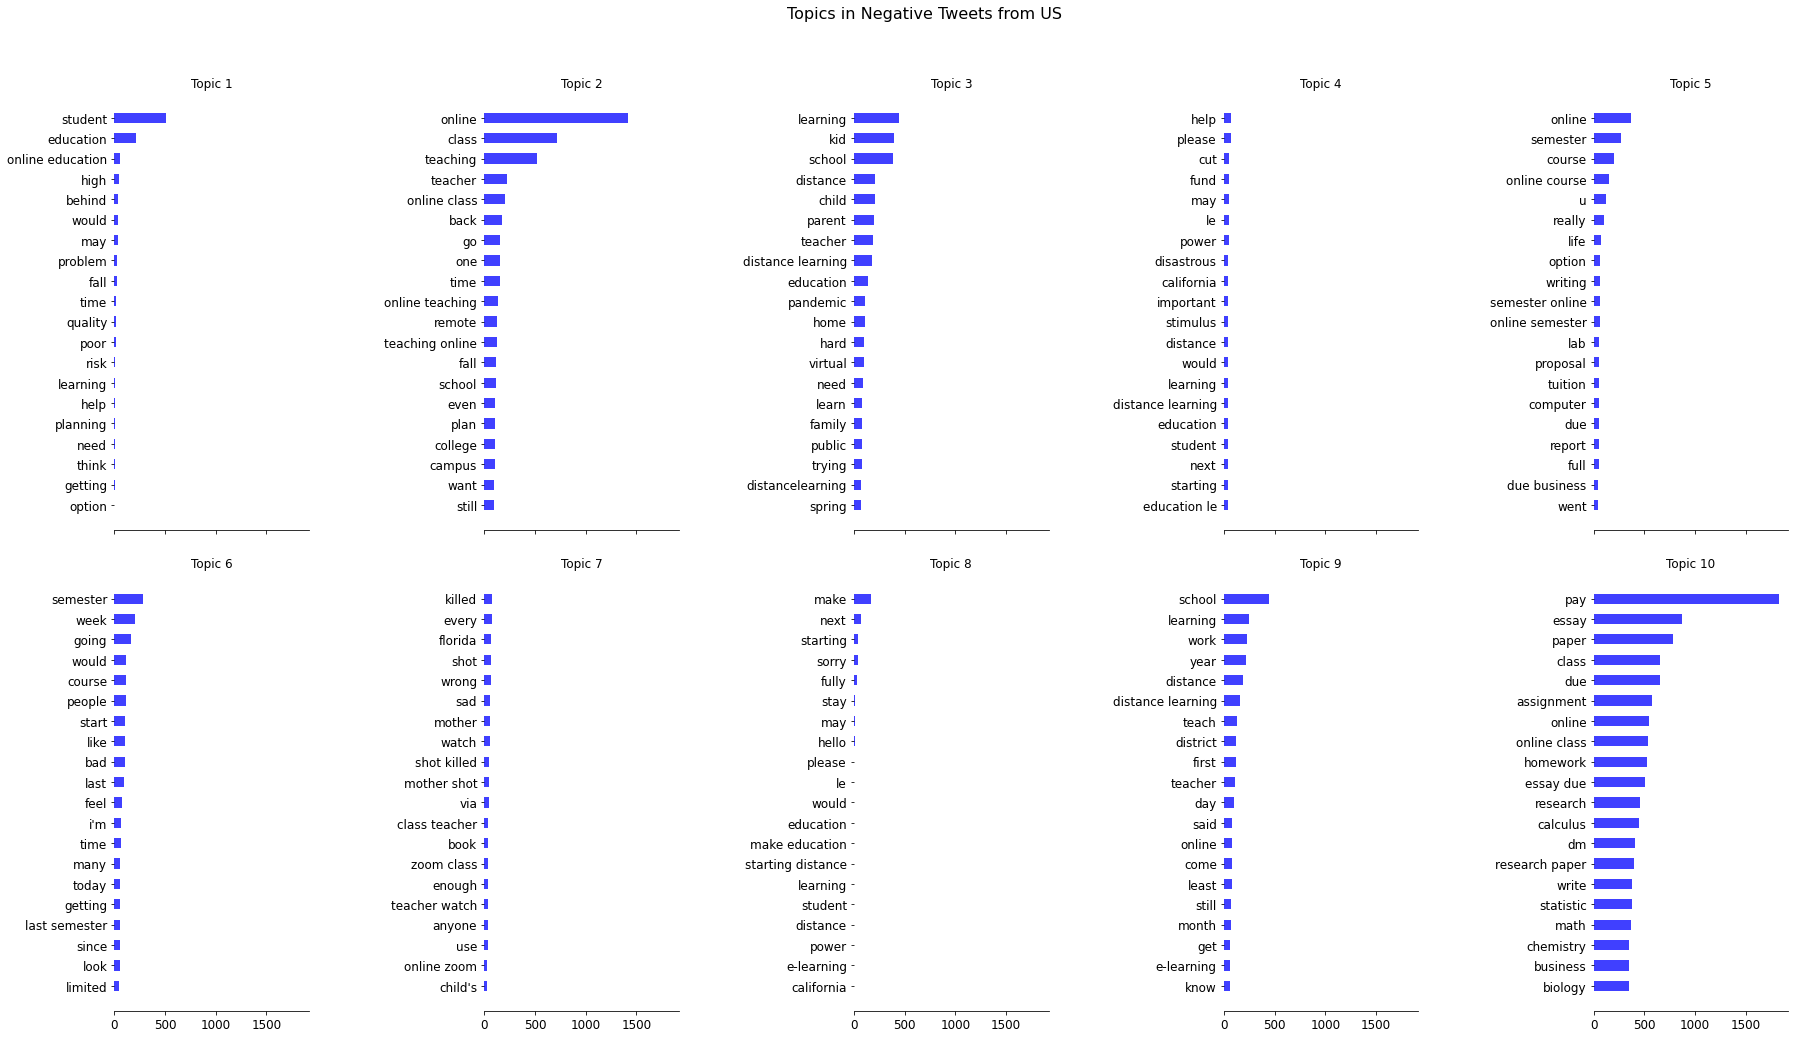

In [78]:
# US-wide Negative topics
us_neg_tm_tuple = perform_topic_modeling_and_plot(content=entire_us_sentiment_series[1], topic_num=10, top_word_count=20, plot_title='Topics in Negative Tweets from US')

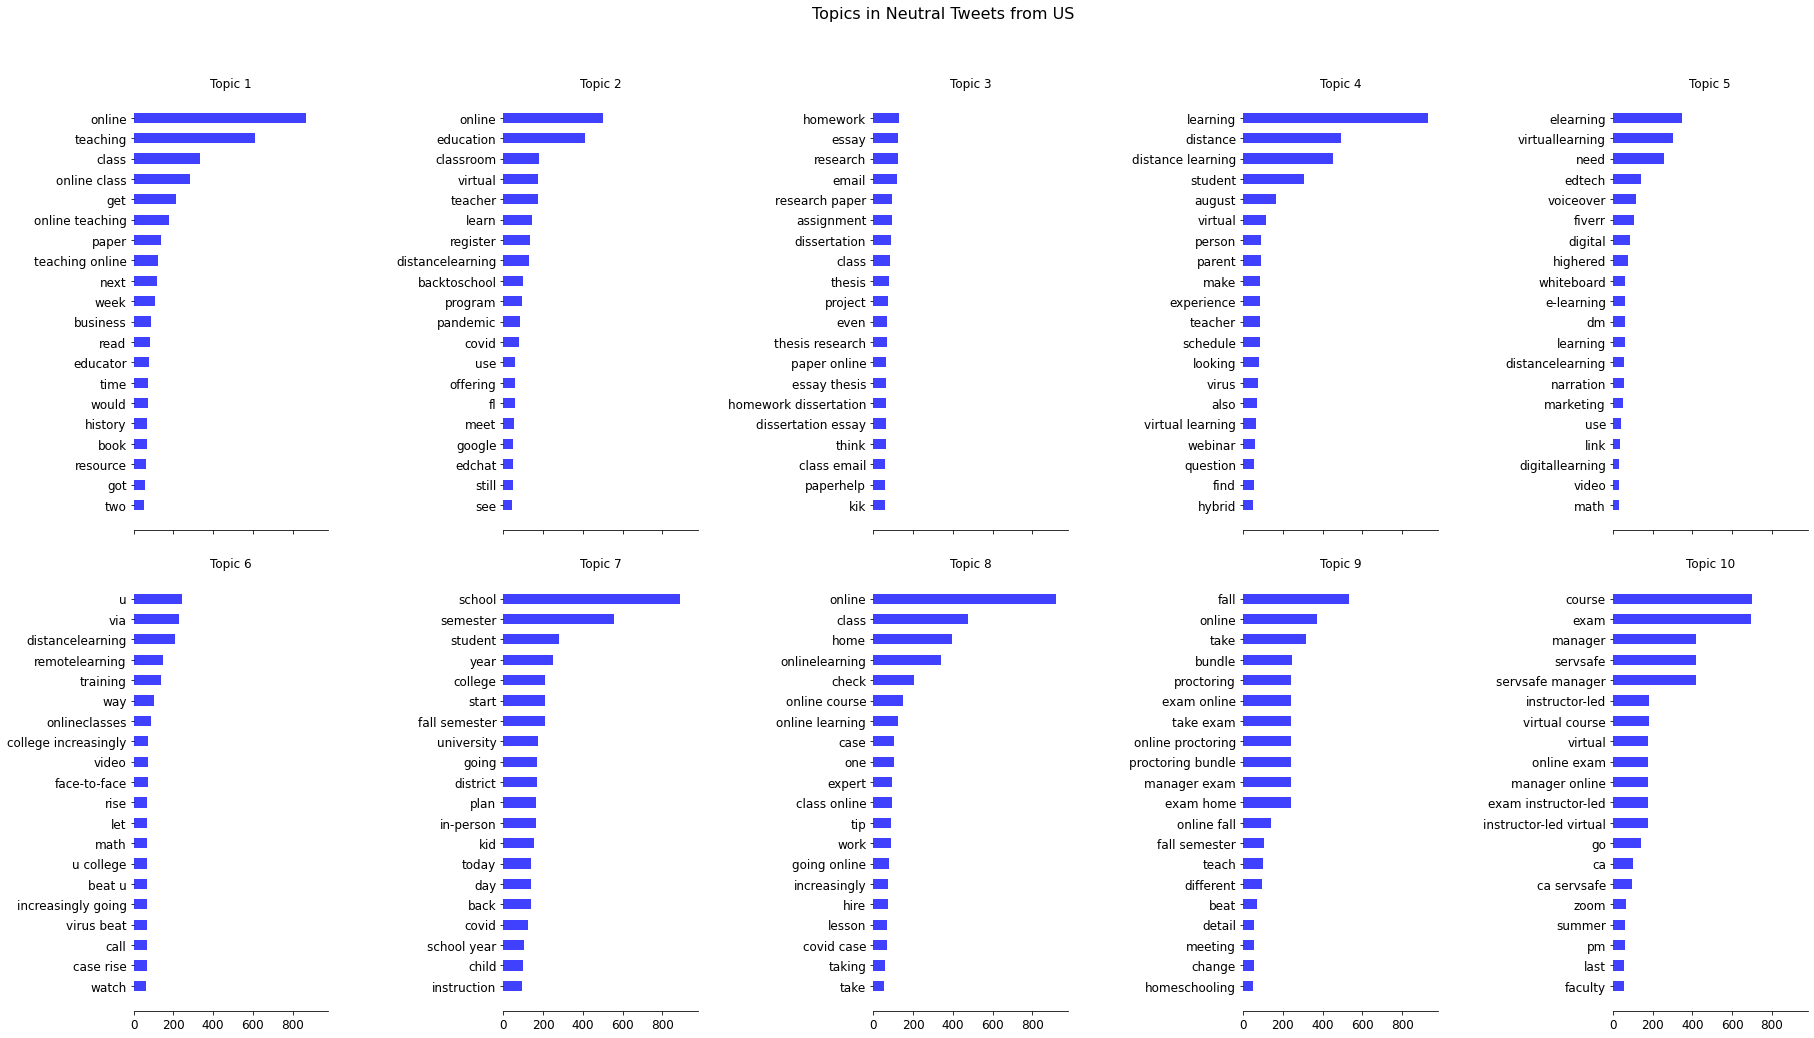

In [79]:
## US-wide Neutral topics
us_neu_tm_tuple = perform_topic_modeling_and_plot(content=entire_us_sentiment_series[2], topic_num=10, top_word_count=20, plot_title='Topics in Neutral Tweets from US')

### US Southeast Region

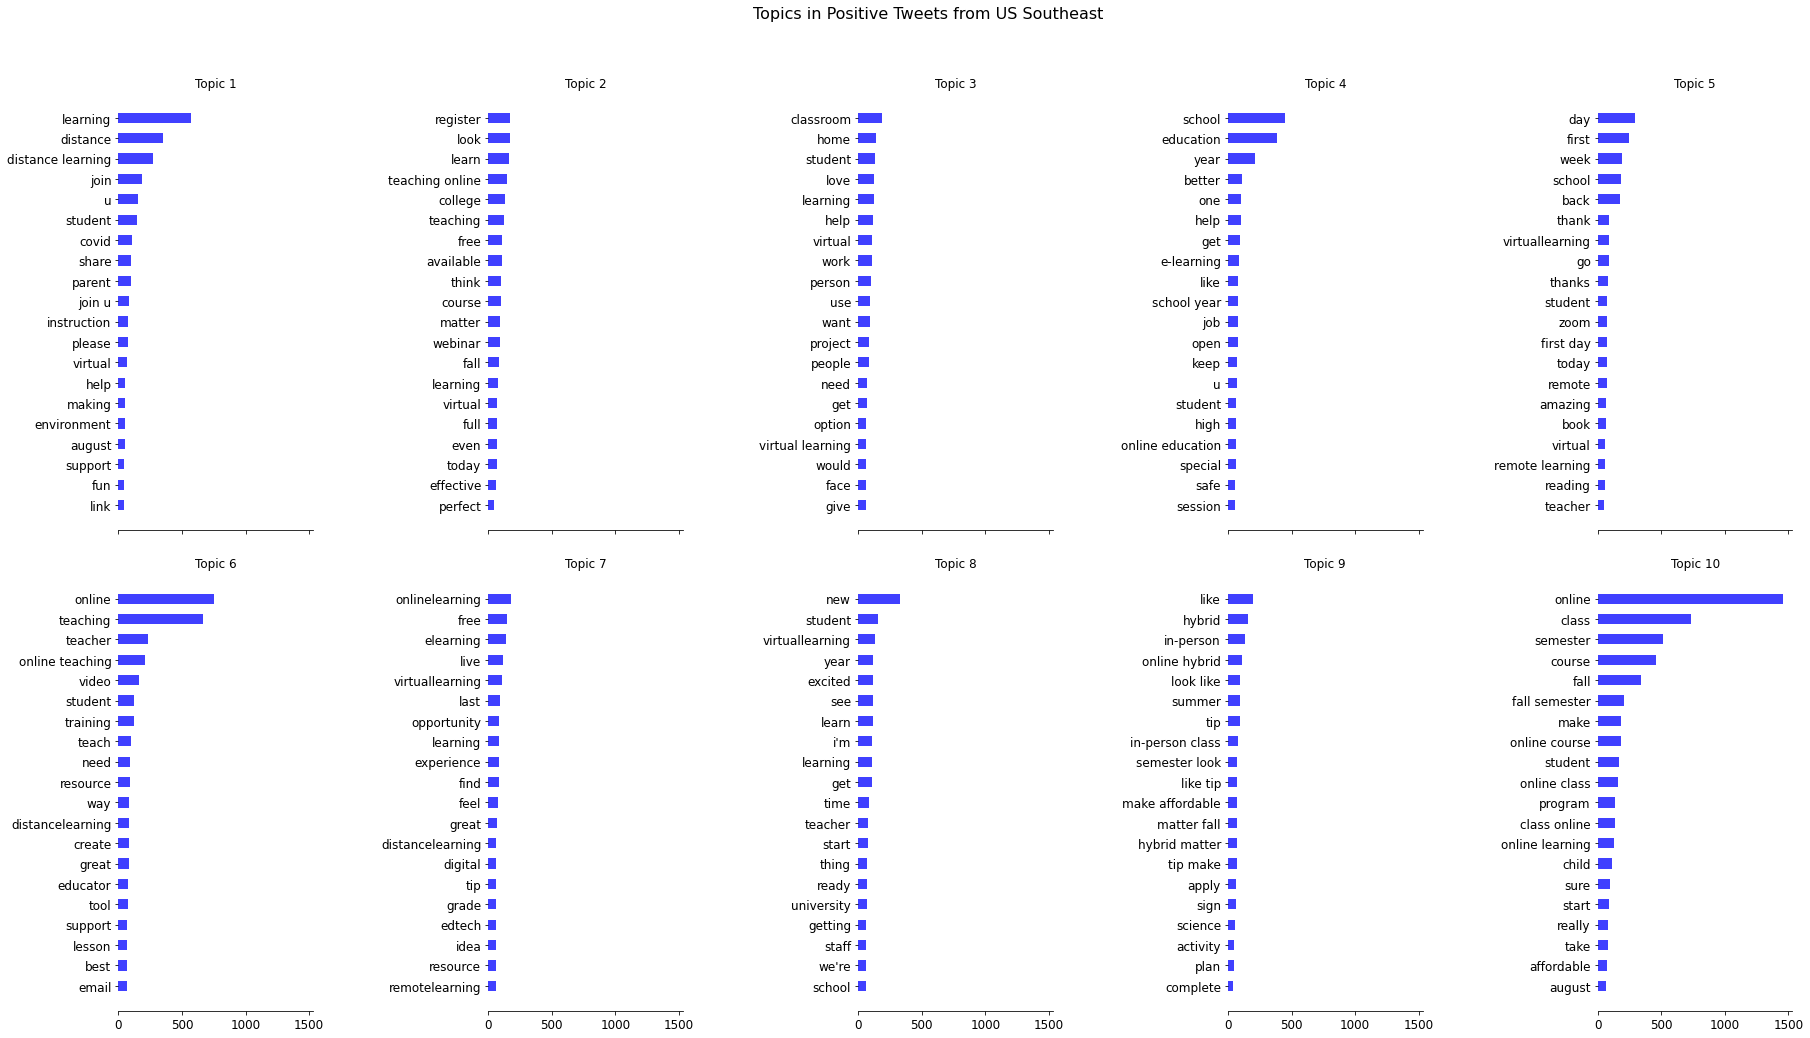

In [74]:
# Southeast Positive topics - Again, getting 20 Topics for the majority class: Positive
se_pos_tm_tuple = perform_topic_modeling_and_plot(content=se_sentiment_series[0], topic_num=10, top_word_count=20, plot_title='Topics in Positive Tweets from US Southeast')

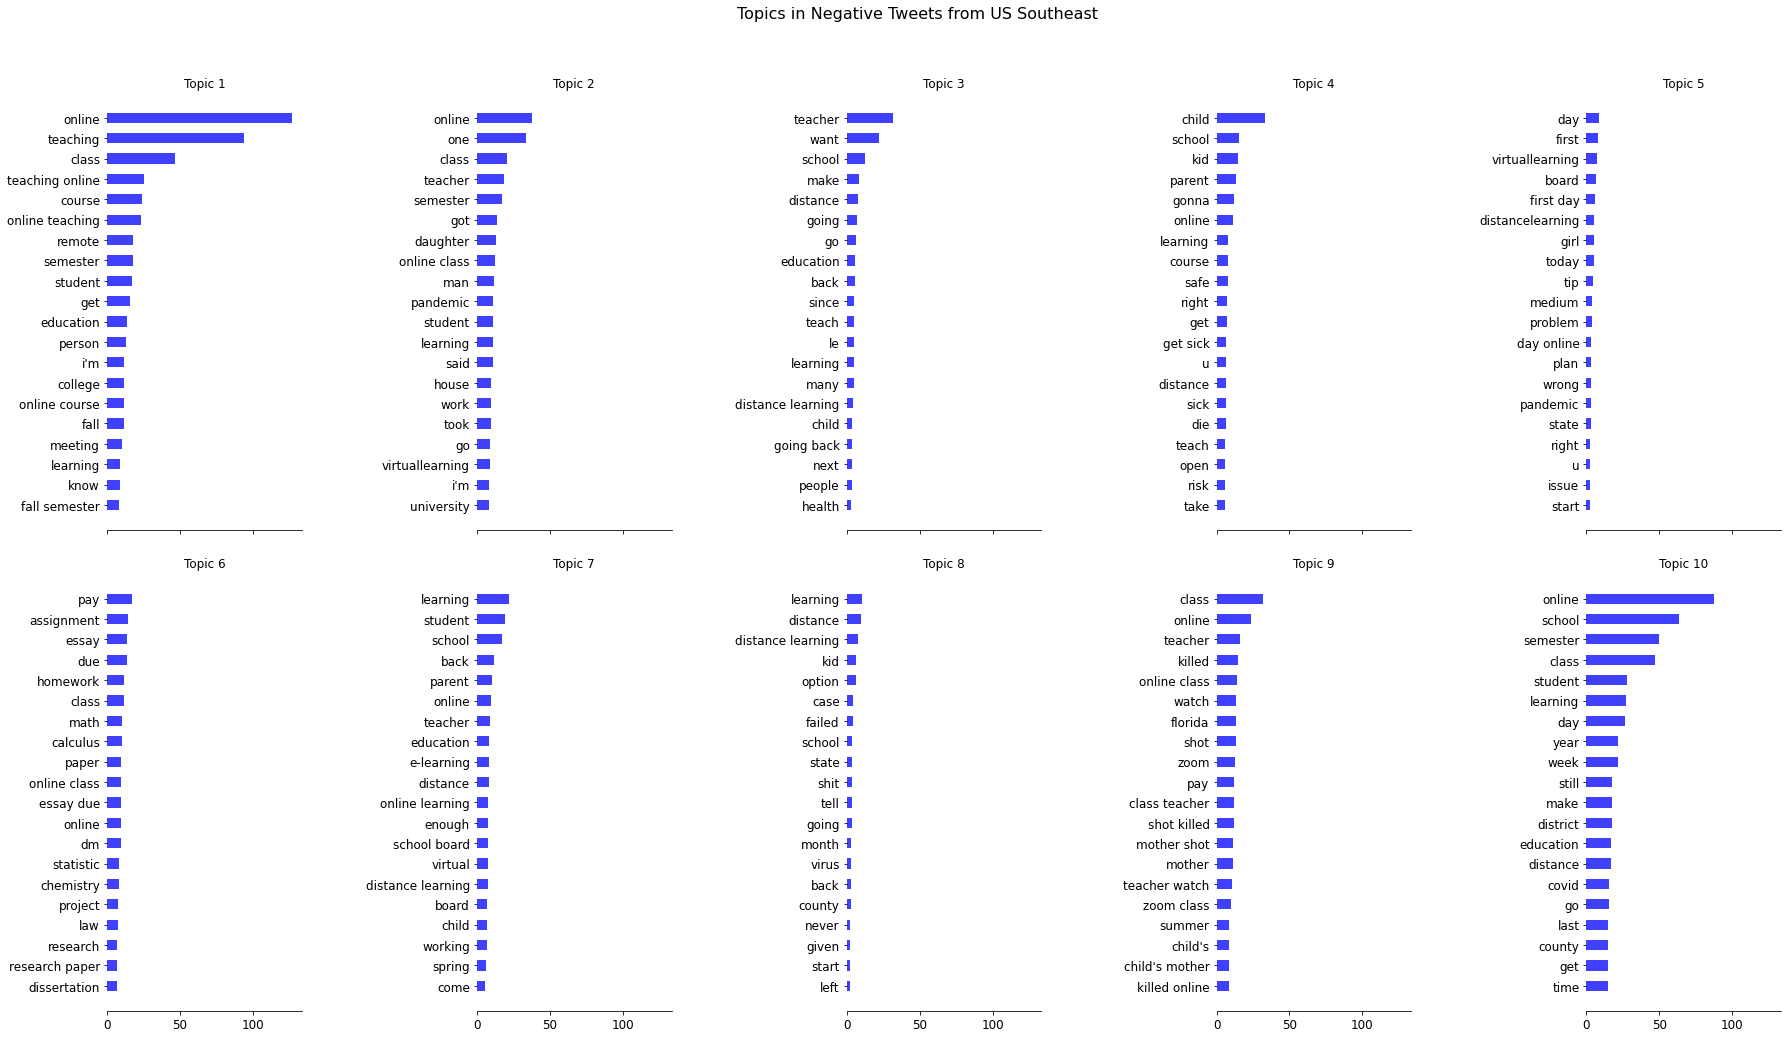

In [75]:
# Southeast Negative topics
se_neg_tm_tuple = perform_topic_modeling_and_plot(content=se_sentiment_series[1], topic_num=10, top_word_count=20, plot_title='Topics in Negative Tweets from US Southeast')

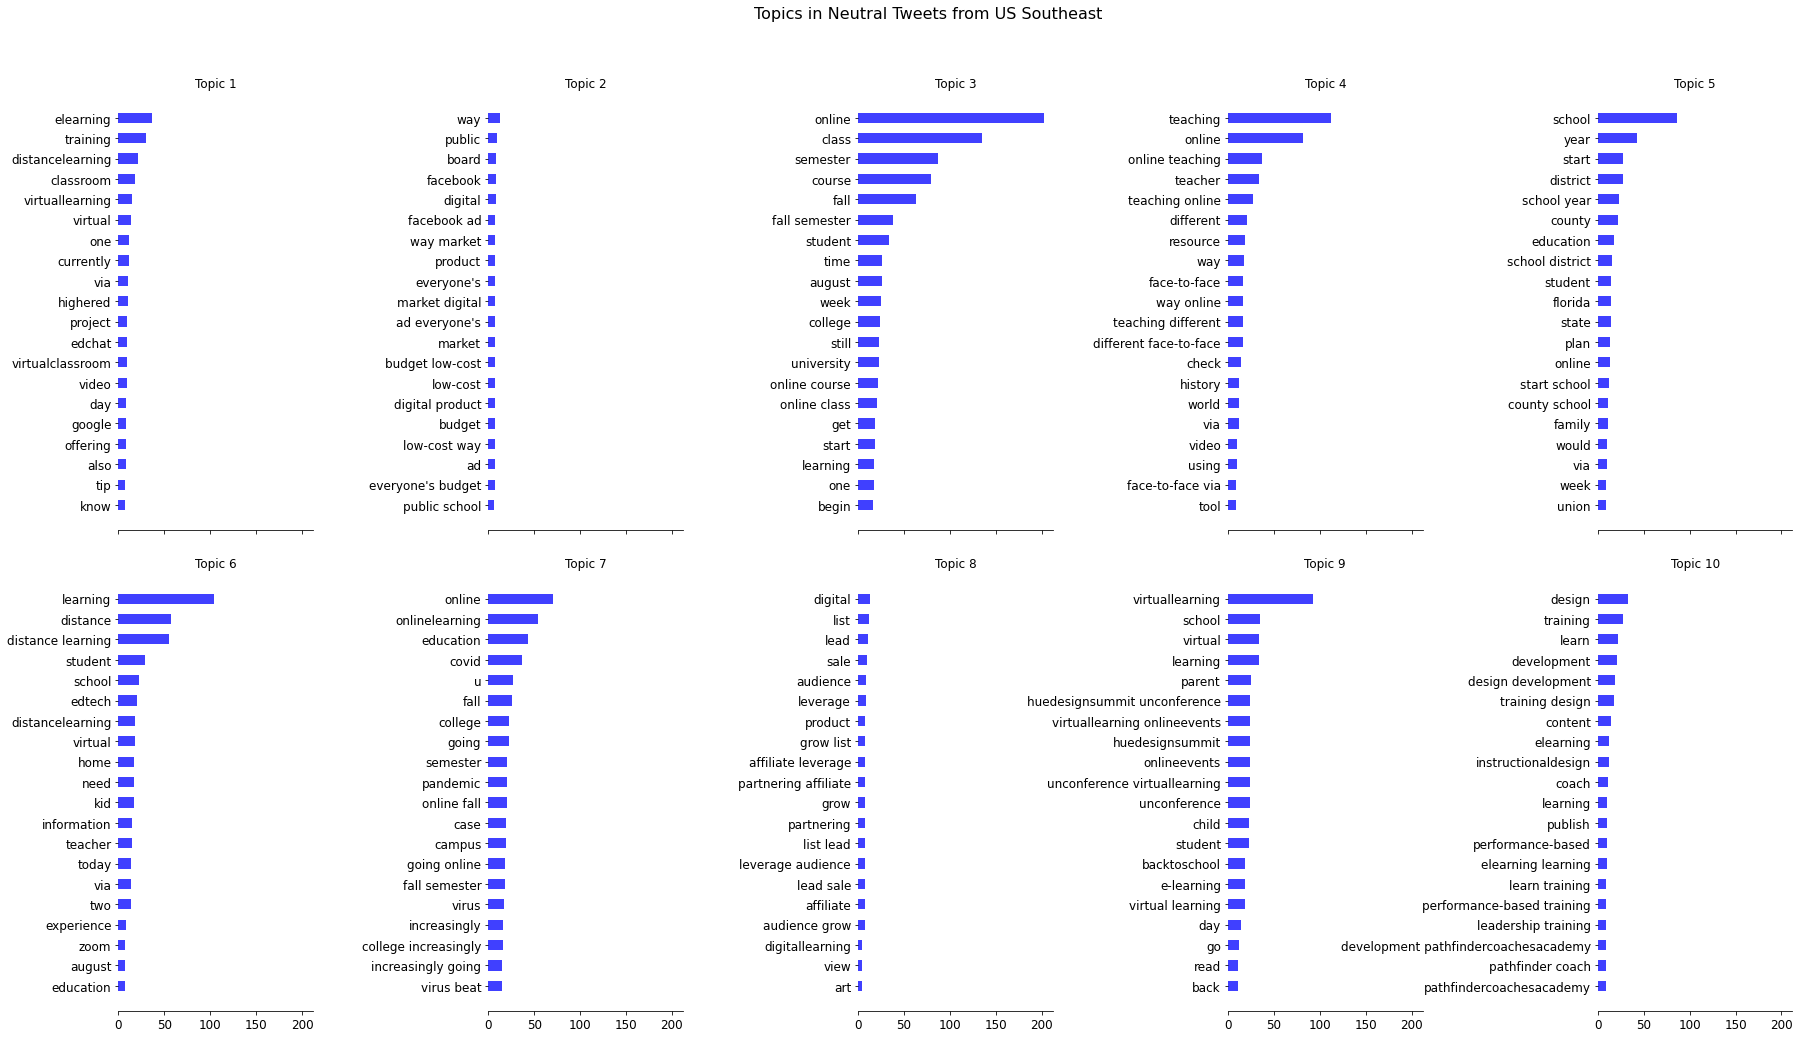

In [76]:
# Southeast Neutral topics
se_neu_tm_tuple = perform_topic_modeling_and_plot(content=se_sentiment_series[2], topic_num=10, top_word_count=20, plot_title='Topics in Neutral Tweets from US Southeast')

### Alabama

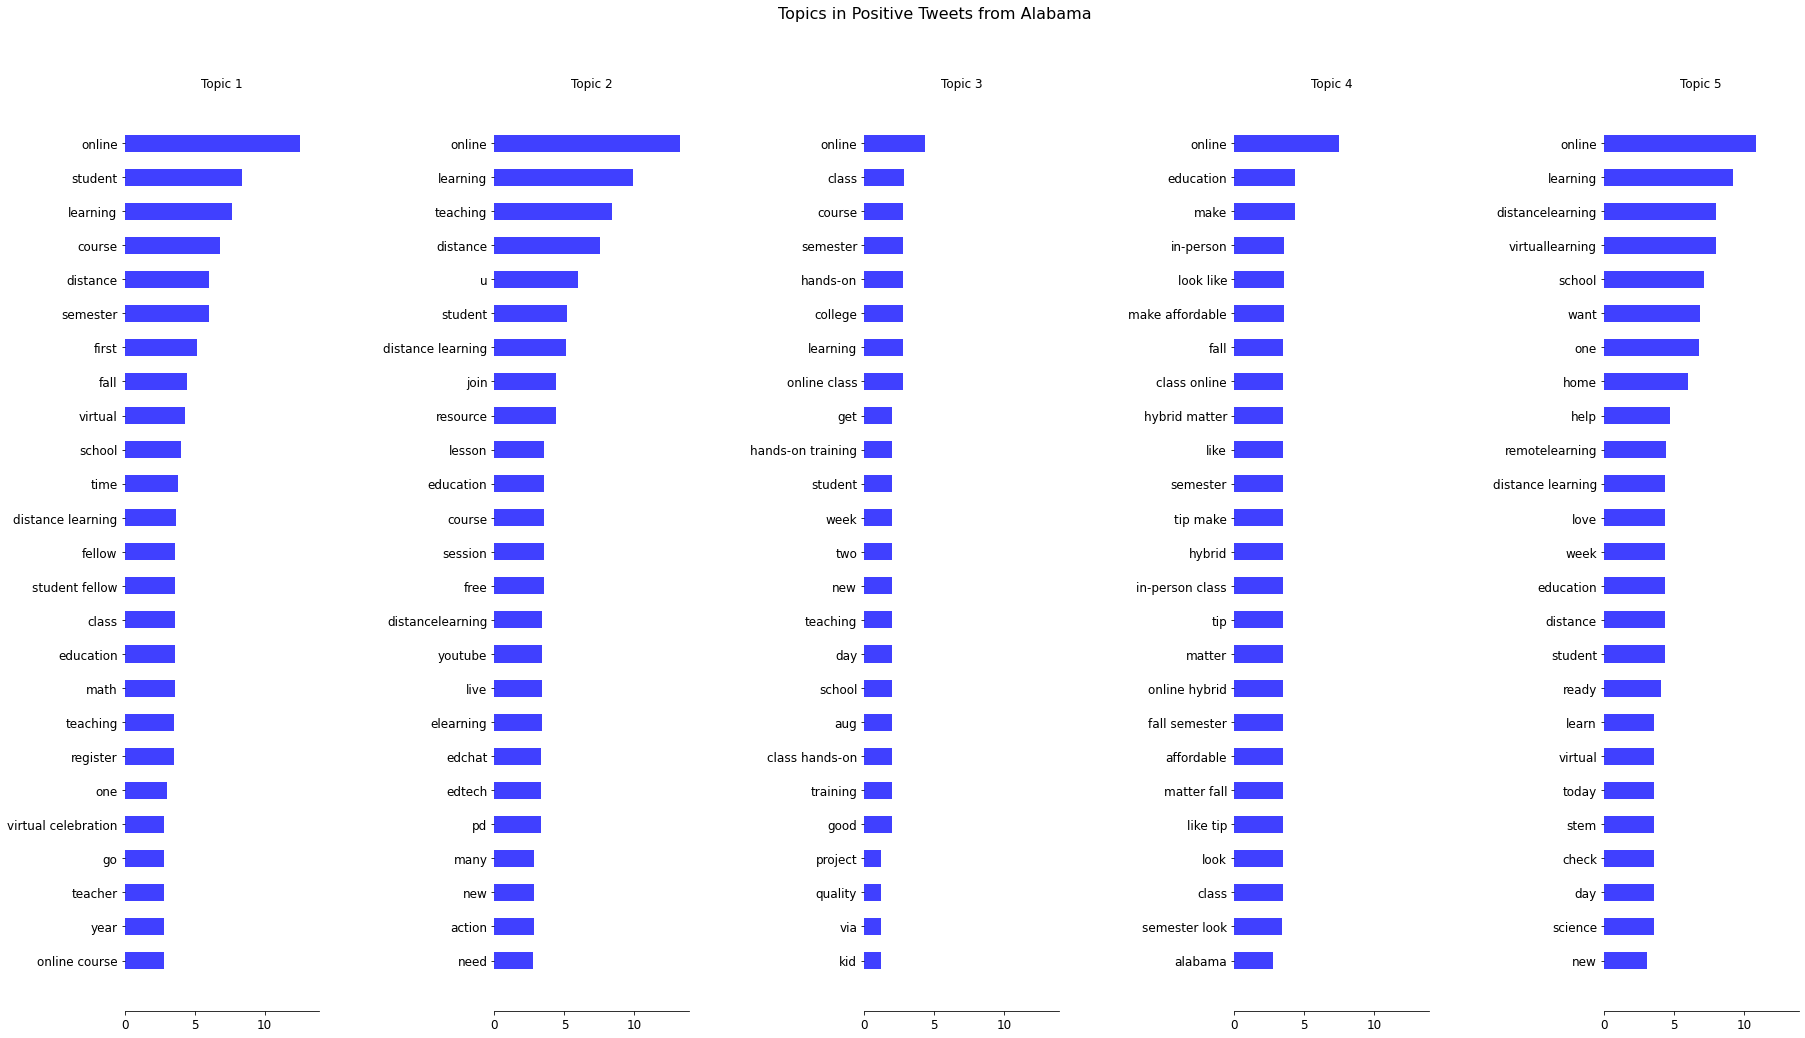

In [71]:
al_pos_tm_tuple = perform_topic_modeling_and_plot(content=alabama_sentiment_series[0], topic_num=5, top_word_count=25, plot_title='Topics in Positive Tweets from Alabama')

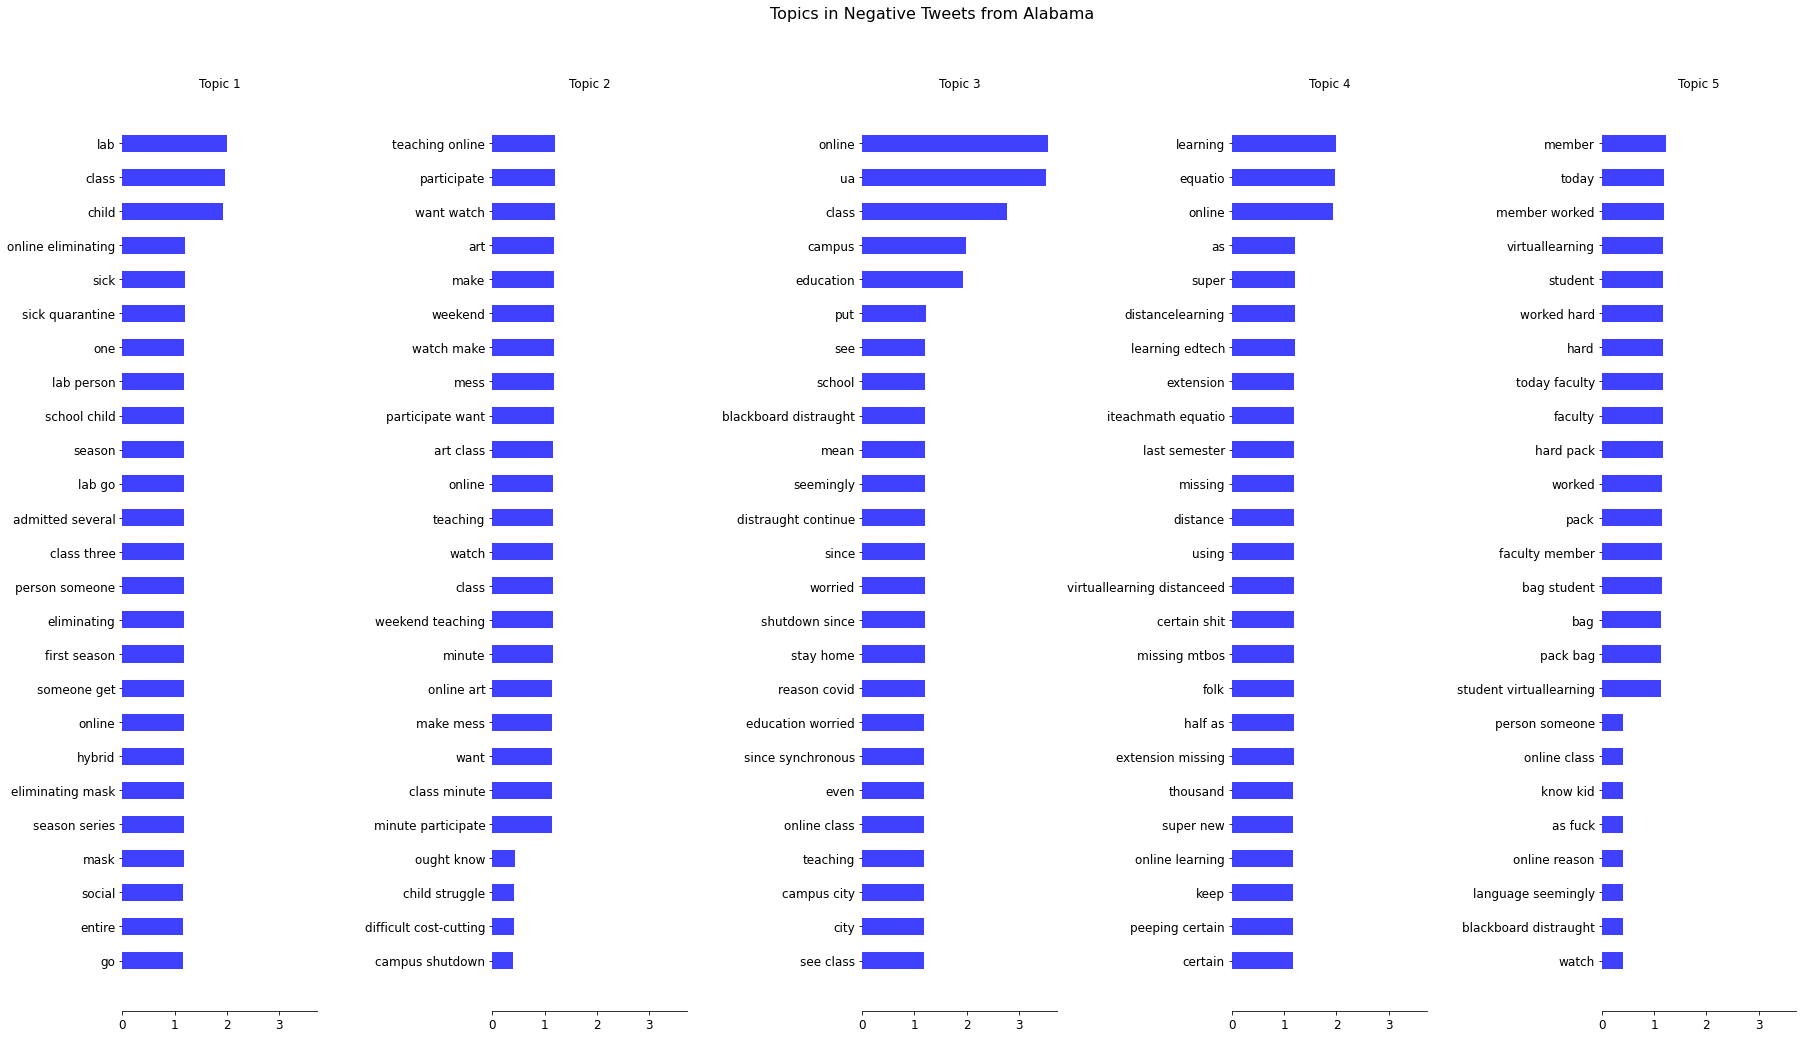

In [72]:
al_neg_tm_tuple = perform_topic_modeling_and_plot(content=alabama_sentiment_series[1], topic_num=5, top_word_count=25, plot_title='Topics in Negative Tweets from Alabama')
al_neg_lda = al_neg_tm_tuple[0]
al_neg_dtm = al_neg_tm_tuple[1]
al_neg_cv = al_neg_tm_tuple[2]

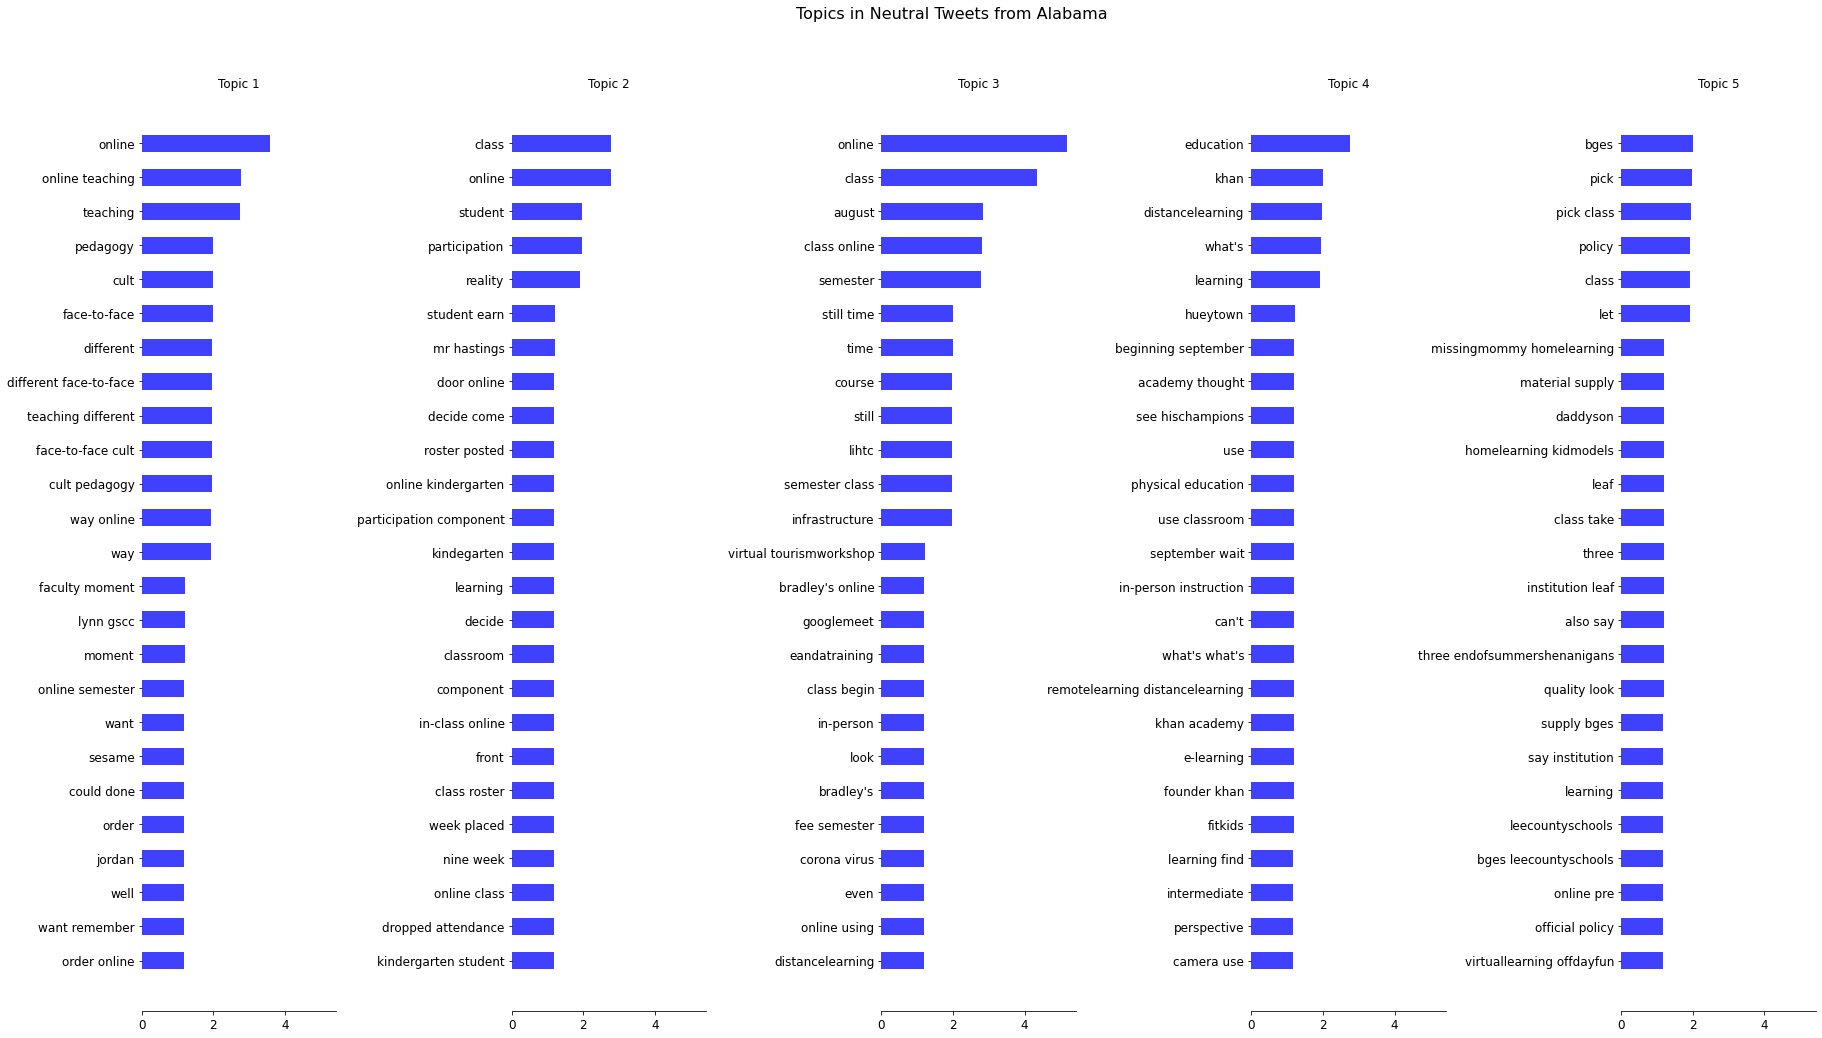

In [80]:
al_neu_tm_tuple = perform_topic_modeling_and_plot(content=alabama_sentiment_series[2], topic_num=5, top_word_count=25, plot_title='Topics in Neutral Tweets from Alabama')

## Question 4: Insights/Recommendations:
Insights: 
* While this notebook only focuses in on a single Region and State, this process could be repeated for any Regions and/or States of interest. 

Recommendations:
* For other Data Scientists seeking to expand upon this work. Topic Modeling complements the Sentiment Classifer and provides contextual insight into the words and terms that people are using in the various Positive, Negative or Neutral Tweets. Topic Modeling is an unsupervised learning technique doesn't have to be trained so it is faster and easier to generate than the Sentiment Classifier (which uses supervised learning requiring labeled data). I recommend using Topic Modeling instead of Word Clouds based on frequent words/terms to provide a more organized method of presenting contextual insight.


## Future Work:
* Create a dashboard/app that would allow the user to select specific Regions and/or States for Topic Modeling. Also allow for setting the desired number of topics and top word count. 

# Topic Visualization with pyLDAvis

In [26]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

## Topics from all US Tweets

In [56]:
# POSITIVE
pyLDAvis.sklearn.prepare(us_pos_tm_tuple[0], us_pos_tm_tuple[1], us_pos_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.296107  0.151781       1        1  13.216187
0      0.041727 -0.224030       2        1  13.077284
9     -0.069017 -0.190602       3        1  10.914730
5     -0.155212 -0.040708       4        1  10.499570
4      0.059610 -0.226134       5        1   9.800862
3     -0.097126 -0.042578       6        1   9.298928
1      0.277511  0.054709       7        1   9.171592
6     -0.131209  0.295697       8        1   8.520333
7      0.028304  0.120116       9        1   8.393482
2     -0.250696  0.101750      10        1   7.107032, topic_info=          Term          Freq         Total Category  logprob  loglift
204     online  13584.000000  13584.000000  Default  30.0000  30.0000
162   learning   6963.000000   6963.000000  Default  29.0000  29.0000
60      course   4293.000000   4293.000000  Default  28.0000  28.0000
50       class   4683.000000   4683.000000  Default  27.0000  27.0000
262     school   4509.000000   4509.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
113       full    339.669278    459.015664  Topic10  -3.9805   2.3430
326          u    589.613606   1765.912472  Topic10  -3.4290   1.5471
166       like    500.188873   1819.823751  Topic10  -3.5935   1.3526
85   education    435.784113   2839.214972  Topic10  -3.7313   0.7699
314       time    277.192440   1666.979856  Topic10  -4.1837   0.8500

[395 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         6  0.998774      able
1         1  0.997599   academy
2         2  0.788026    access
2         6  0.210405    access
3         1  0.112051  activity
...     ...       ...       ...
351       8  0.048340   writing
351       9  0.947460   writing
352       4  0.000499      year
352       5  0.998947      year
354       3  0.998561      zoom

[520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 10, 6, 5, 4, 2, 7, 8, 3])

In [55]:
# NEGATIVE
pyLDAvis.sklearn.prepare(us_neg_tm_tuple[0], us_neg_tm_tuple[1], us_neg_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.025354 -0.317189       1        1  47.231615
1     -0.227497 -0.023475       2        1  13.693632
2     -0.129179  0.237845       3        1   9.262043
8     -0.200061  0.176138       4        1   8.495743
5     -0.145211  0.059249       5        1   5.558825
4     -0.134764 -0.228620       6        1   5.399381
3      0.305018  0.146307       7        1   4.631368
6      0.064525 -0.128801       8        1   2.408116
0      0.177711  0.122715       9        1   2.197895
7      0.264105 -0.044168      10        1   1.121382, topic_info=                  Term         Freq        Total Category  logprob  loglift
261             online  2278.000000  2278.000000  Default  30.0000  30.0000
388            student   635.000000   635.000000  Default  29.0000  29.0000
52               class  1326.000000  1326.000000  Default  28.0000  28.0000
284                pay  1926.000000  1926.000000  Default  27.0000  27.0000
229               make   312.000000   312.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
102         e-learning     0.151956    99.755945  Topic10  -8.3328  -1.9963
88   distance learning     0.151923   376.374743  Topic10  -8.3330  -3.3244
169               help     0.151549   171.518593  Topic10  -8.3355  -2.5409
143               fund     0.151428    69.709875  Topic10  -8.3363  -1.6414
73                 cut     0.151379    76.863566  Topic10  -8.3366  -1.7394

[452 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
0         3  0.204666            access
0         4  0.767498            access
5         4  0.569381          actually
5         5  0.409243          actually
6         7  0.990439  afterschoolworks
...     ...       ...               ...
447       6  0.985518           writing
448       8  0.991183             wrong
449       4  0.993292              year
450       2  0.988309              zoom
451       8  0.967368        zoom class

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 3, 9, 6, 5, 4, 7, 1, 8])

In [57]:
# NEUTRAL
pyLDAvis.sklearn.prepare(us_neu_tm_tuple[0], us_neu_tm_tuple[1], us_neu_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.094461  0.041293       1        1  15.762038
9      0.126001 -0.366664       2        1  12.751608
3      0.166762  0.049214       3        1  11.585349
8     -0.210557  0.008290       4        1  10.536994
0     -0.257995  0.053437       5        1  10.320656
7     -0.268168  0.043084       6        1  10.308052
1     -0.104183  0.108864       7        1   7.990609
5      0.218457  0.145721       8        1   7.781907
2     -0.007743 -0.242954       9        1   6.690980
4      0.242964  0.159715      10        1   6.271807, topic_info=                                Term         Freq        Total Category  \
125                           online  2545.000000  2545.000000  Default   
106                         learning  1089.000000  1089.000000  Default   
164                           school   814.000000   814.000000  Default   
59                              exam   684.000000   684.000000  Default   
32                            course   703.000000   703.000000  Default   
..                               ...          ...          ...      ...   
157  remotelearning distancelearning     0.106748    53.983154  Topic10   
205                          virtual     0.114239   472.387691  Topic10   
10                   blendedlearning     0.106793    56.995922  Topic10   
203                              via     0.108214   302.436094  Topic10   
177                            still     0.107354   111.337768  Topic10   

     logprob  loglift  
125  30.0000  30.0000  
106  29.0000  29.0000  
164  28.0000  28.0000  
59   27.0000  27.0000  
32   26.0000  26.0000  
..       ...      ...  
157  -9.9539  -3.4568  
205  -9.8861  -5.5582  
10   -9.9535  -3.5107  
203  -9.9402  -5.1664  
177  -9.9482  -4.1751  

[362 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         3  0.651084      access
0         5  0.334340      access
1         3  0.988022        also
2         9  0.976757  assignment
2        10  0.018257  assignment
...     ...       ...         ...
219       3  0.348845        work
219       6  0.651177        work
220       5  0.993095       would
221       1  0.995347        year
222       2  0.981114        zoom

[341 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 4, 9, 1, 8, 2, 6, 3, 5])

## Topics in Tweets from the Southest

In [58]:
# POSITIVE
pyLDAvis.sklearn.prepare(se_pos_tm_tuple[0], se_pos_tm_tuple[1], se_pos_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.039114  0.253034       1        1  19.133330
5     -0.042229  0.282027       2        1  12.085766
3     -0.015354 -0.099830       3        1  10.812464
7     -0.103546 -0.102468       4        1  10.100955
0     -0.110790 -0.094113       5        1   9.727325
6     -0.006591  0.020912       6        1   9.075151
4     -0.084745 -0.215763       7        1   8.853723
2     -0.074443 -0.048709       8        1   7.749015
1     -0.000180  0.052137       9        1   7.093731
8      0.476992 -0.047226      10        1   5.368539, topic_info=           Term         Freq        Total Category  logprob  loglift
178      online  2112.000000  2112.000000  Default  30.0000  30.0000
266    teaching   757.000000   757.000000  Default  29.0000  29.0000
36        class   675.000000   675.000000  Default  28.0000  28.0000
137    learning  1071.000000  1071.000000  Default  27.0000  27.0000
228      school   690.000000   690.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
250       state    13.503192    52.669258  Topic10  -5.0257   1.5635
127  interested    17.316267    67.999869  Topic10  -4.7770   1.5568
1        access    17.121591    73.667767  Topic10  -4.7883   1.4654
131        keep    13.132843    86.128176  Topic10  -5.0536   1.0439
252       still     9.716300   114.602627  Topic10  -5.3549   0.4569

[422 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.218668    able
0         5  0.160357    able
0         6  0.291558    able
0         8  0.320714    able
1         1  0.244340  access
...     ...       ...     ...
312       4  0.358043    year
313       7  0.239731     yes
313       8  0.695219     yes
313       9  0.047946     yes
314       7  0.986813    zoom

[712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 8, 1, 7, 5, 3, 2, 9])

In [59]:
# NEGATIVE
pyLDAvis.sklearn.prepare(se_neg_tm_tuple[0], se_neg_tm_tuple[1], se_neg_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.075216  0.067181       1        1  26.134456
0     -0.026595  0.157371       2        1  17.002945
1      0.001083  0.143391       3        1  11.894768
6      0.130021 -0.043927       4        1   8.841048
5     -0.312728 -0.176029       5        1   8.543901
8     -0.218559  0.095624       6        1   7.769254
3      0.112957 -0.040639       7        1   7.066859
2      0.136290 -0.095249       8        1   5.120624
7      0.107941 -0.110028       9        1   3.879472
4     -0.005625  0.002305      10        1   3.746673, topic_info=          Term        Freq       Total Category  logprob  loglift
343    teacher   87.000000   87.000000  Default  30.0000  30.0000
346   teaching   93.000000   93.000000  Default  29.0000  29.0000
298     school  114.000000  114.000000  Default  28.0000  28.0000
372       want   33.000000   33.000000  Default  27.0000  27.0000
42       class  146.000000  146.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
87   education    2.369272   45.690852  Topic10  -4.4467   0.3250
251     parent    2.082466   25.252118  Topic10  -4.5757   0.7889
119    florida    2.033806   24.951374  Topic10  -4.5994   0.7773
353      think    1.965552   20.287230  Topic10  -4.6335   0.9501
235     online    2.131456  277.505670  Topic10  -4.5525  -1.5847

[477 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.802246          :(
2         2  0.167606      access
2         4  0.335212      access
2         6  0.167606      access
2         9  0.167606      access
...     ...       ...         ...
395       4  0.141114         yet
395       6  0.282227         yet
396       2  0.276225        zoom
396       6  0.662940        zoom
397       6  0.911859  zoom class

[897 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 2, 7, 6, 9, 4, 3, 8, 5])

In [60]:
# NEUTRAL
pyLDAvis.sklearn.prepare(se_neu_tm_tuple[0], se_neu_tm_tuple[1], se_neu_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.212953  0.082533       1        1  23.153294
6     -0.136283  0.216282       2        1  12.680462
5     -0.112081 -0.189229       3        1  12.080313
4     -0.157205 -0.094463       4        1  10.000161
3     -0.095912  0.126285       5        1   9.850243
8     -0.046961 -0.221866       6        1   9.457641
9      0.264274 -0.097556       7        1   7.859080
0      0.132782 -0.119229       8        1   6.821788
7      0.173611  0.139880       9        1   4.161772
1      0.190728  0.157364      10        1   3.935245, topic_info=                 Term        Freq       Total Category  logprob  loglift
149            online  335.000000  335.000000  Default  30.0000  30.0000
218          teaching  101.000000  101.000000  Default  29.0000  29.0000
197            school  149.000000  149.000000  Default  28.0000  28.0000
246   virtuallearning   90.000000   90.000000  Default  27.0000  27.0000
124          learning  176.000000  176.000000  Default  26.0000  26.0000
..                ...         ...         ...      ...      ...      ...
256              week    0.469440   41.085314  Topic10  -6.1821  -1.2367
240               via    0.546809   59.224927  Topic10  -6.0296  -1.4498
208             state    0.209612   15.955059  Topic10  -6.9884  -1.0971
62   distancelearning    0.248523   47.406648  Topic10  -6.8181  -2.0158
197            school    0.320090  149.122490  Topic10  -6.5651  -2.9087

[393 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.216430         access
0         2  0.324645         access
0         3  0.432860         access
1        10  0.910380             ad
2        10  0.910412  ad everyone's
...     ...       ...            ...
261       3  0.022301           year
261       4  0.958924           year
262       1  0.343911           zoom
262       2  0.068782           zoom
262       3  0.550257           zoom

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 5, 4, 9, 10, 1, 8, 2])

## Topics from Tweets from Alabama

In [61]:
# POSITIVE
pyLDAvis.sklearn.prepare(al_pos_tm_tuple[0], al_pos_tm_tuple[1], al_pos_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.078176 -0.042890       1        1  27.861133
4     -0.003791  0.082348       2        1  25.865376
0      0.012678  0.007652       3        1  24.393898
3     -0.079786 -0.044482       4        1  15.267234
2     -0.007277 -0.002628       5        1   6.612359, topic_info=                Term       Freq      Total Category  logprob  loglift
311         semester  11.000000  11.000000  Default  30.0000  30.0000
57             class  10.000000  10.000000  Default  29.0000  29.0000
62           college   3.000000   3.000000  Default  28.0000  28.0000
158         hands-on   3.000000   3.000000  Default  27.0000  27.0000
250     online class   3.000000   3.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
379              via   0.573808   3.778721   Topic5  -5.2082   0.8314
192              kid   0.573334   3.757963   Topic5  -5.2090   0.8361
255  online teaching   0.571301   3.820615   Topic5  -5.2126   0.8160
371           trying   0.572033   4.519530   Topic5  -5.2113   0.6493
334            start   0.570650   4.536270   Topic5  -5.2137   0.6431

[283 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         3  0.753043           :-:
2         2  0.731001          able
6         1  0.582821        action
7         2  0.487155      activity
7         3  0.243577      activity
...     ...       ...           ...
404       1  0.720504       youtube
405       1  0.585203  youtube live
406       1  0.209513          zoom
406       2  0.419026          zoom
406       3  0.209513          zoom

[408 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])

In [62]:
# NEGATIVE
pyLDAvis.sklearn.prepare(al_neg_tm_tuple[0], al_neg_tm_tuple[1], al_neg_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.065059  0.023131       1        1  36.540883
3      0.057377  0.032335       2        1  28.462176
0      0.005975 -0.059175       3        1  23.225266
1      0.001057  0.001730       4        1   6.462292
4      0.000650  0.001979       5        1   5.309383, topic_info=                      Term      Freq     Total Category  logprob  loglift
261                student  1.000000  1.000000  Default  30.0000  30.0000
288        virtuallearning  1.000000  1.000000  Default  29.0000  29.0000
46                   class  2.000000  2.000000  Default  28.0000  28.0000
270        teaching online  1.000000  1.000000  Default  27.0000  27.0000
170                 member  0.000000  0.000000  Default  26.0000  26.0000
..                     ...       ...       ...      ...      ...      ...
196              online ua  0.057956  1.156280   Topic5  -5.7588  -0.0576
24   blackboard distraught  0.058300  1.192864   Topic5  -5.7529  -0.0828
0                       :(  0.057743  1.152715   Topic5  -5.7625  -0.0582
306                worried  0.057587  1.155918   Topic5  -5.7652  -0.0637
211                    put  0.057593  1.165375   Topic5  -5.7651  -0.0717

[250 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
0         1  0.867517                   :(
1         3  0.985175                acted
2         3  0.993025  acted irresponsibly
4         3  0.948709     admitted several
5         3  0.946553                 also
...     ...       ...                  ...
305       2  0.935560       working forced
306       1  0.865113              worried
307       1  0.855549       worried corona
308       1  0.880540                would
309       1  0.865940      would different

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

In [63]:
# NEUTRAL
pyLDAvis.sklearn.prepare(al_neu_tm_tuple[0], al_neu_tm_tuple[1], al_neu_tm_tuple[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.068484 -0.019542       1        1  28.597990
4      0.037916 -0.050142       2        1  21.751725
1      0.008826  0.026124       3        1  18.532383
3      0.019601  0.013691       4        1  16.566818
0      0.002140  0.029869       5        1  14.551085, topic_info=                Term      Freq     Total Category  logprob  loglift
247  online teaching  1.000000  1.000000  Default  30.0000  30.0000
343         teaching  2.000000  2.000000  Default  29.0000  29.0000
114        education  1.000000  1.000000  Default  28.0000  28.0000
239           online  6.000000  6.000000  Default  27.0000  27.0000
81              cult  1.000000  1.000000  Default  26.0000  26.0000
..               ...       ...       ...      ...      ...      ...
239           online  1.269278  6.206014   Topic5  -4.0467   0.3404
319           sesame  0.422721  1.089397   Topic5  -5.1461   0.9808
186           jordan  0.421625  1.084977   Topic5  -5.1487   0.9823
389             want  0.423199  1.096763   Topic5  -5.1450   0.9752
125          explain  0.419731  1.084020   Topic5  -5.1532   0.9787

[242 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         2  0.851599    also say
6         1  0.835205   announced
9         2  0.904587     art one
15        1  0.949257      august
24        1  0.822083    bc class
...     ...       ...         ...
391       5  0.757672         way
392       5  0.760345  way online
397       4  0.729948      what's
402       1  0.807819    workshop
408       1  0.832906     youtube

[130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])